# Mounting to drive

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [40]:
!pip install tensorflow

In [41]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input, Flatten, MaxPooling1D, SpatialDropout1D, Activation

from keras.callbacks import EarlyStopping

from numpy import array
from sklearn.metrics import classification_report

import gensim
from gensim import models
from gensim.models import Word2Vec
# import fasttext.util
import pandas as pd
import numpy as np

# Loading Model

# Load Dataset

In [42]:
train_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/train.csv")
val_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/dev.csv")
test_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/test.csv")

In [43]:
print(f'train: {train_dataset.shape}\nval: {val_dataset.shape}\ntest: {test_dataset.shape}')

train: (2700, 2)
val: (1330, 2)
test: (2016, 2)


# Oversampling

In [44]:
train_x = train_dataset['text']
train_y = train_dataset['label']

val_x = val_dataset['text']
val_y = val_dataset['label']

test_x = test_dataset['text']
test_y = test_dataset['label']

# Embedding Setup

In [45]:
tokenizer=Tokenizer(oov_token = "<OOV>", split=' ') # Splitting text based on whitespace and adding "Out of vocabulary"
tokenizer.fit_on_texts(train_x) # Using the tokenizer on out train dataset to tokenize the train dataset
train_encoded=tokenizer.texts_to_sequences(train_x)
# print(train_encoded)


In [46]:
train_padded= pad_sequences(train_encoded, padding='post', maxlen=256)
# print(train_padded)

In [47]:
# padding df_validation
test_encoded=tokenizer.texts_to_sequences(test_x)
test_padded= pad_sequences(test_encoded, padding='post', maxlen=train_padded.shape[1])

In [48]:
# padding df_validation
val_encoded=tokenizer.texts_to_sequences(val_x)
val_padded= pad_sequences(val_encoded, padding='post', maxlen=train_padded.shape[1])

In [49]:
train_padded.shape[1]

256

# Early Stopping

In [50]:
earlystop_callback = EarlyStopping(
    monitor ="val_loss",
    min_delta=0,
    patience=6,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

# Model Configuration Orignal

In [51]:
!pip install keras

In [52]:
from tensorflow.keras.layers import Layer, Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dense, Lambda, GRU
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K


# Attention without maxpool

# Attention for maxpool

# With attention

# Without attention

In [53]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GRU, Dense

# from tensorflow.keras.layers import Embedding, GlobalMaxPool1D, Dense
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam

# num_classes = 3
# learning_rate = 0.001  # Adjust the learning rate as needed
# EMB_DIM = 300
# max_len = train_padded.shape[1]
# vocabulary_size=len(tokenizer.word_index)+1

# model = Sequential()
# model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, input_length=max_len))
# model.add(GRU(150, dropout=0.3, return_sequences=True))
# model.add(GlobalMaxPool1D())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(3, activation='softmax'))  # Assuming 3 classes (0, 1, 2)

# optimizer = Adam(learning_rate=learning_rate)  # Set the learning rate for the optimizer

# model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [54]:
from tensorflow.keras.optimizers import Adam
# Load the pre-trained CBOW Word2Vec model
from gensim.models import Word2Vec
window_size = 2  # Context window size
lstm_units = 150
dense_units = 32
num_classes = 3  # Assuming 3 classes (0, 1, 2)
learning_rate = 0.001  # Learni
cbow_model = Word2Vec.load("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/final/nafi/cbow_model")

# Get the word embeddings from the CBOW model
word_embeddings = cbow_model.wv
# Get the vocabulary size from the tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300  # Define your desired embedding dimension

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_embeddings:
        embedding_matrix[i] = word_embeddings[word]

# Now, you have the embedding matrix with pre-trained word vectors

# Create a new model with the pre-trained embeddings
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=256, weights=[embedding_matrix], trainable=False))

# Add an LSTM layer with dropout and return sequences
model.add(GRU(150, dropout=0.3, return_sequences=True))

# Define a Lambda layer to average the word embeddings within the context window
# model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(150,)))
model.add(GlobalMaxPool1D())

model.add(Dense(dense_units, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Add the learning rate to the Adam optimizer
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Attention + Maxpool

# Training

In [55]:
history = model.fit(train_padded, train_y, epochs=100, batch_size=32, validation_data=(val_padded, val_y), callbacks=[earlystop_callback])

Epoch 1/100
85/85 [==============================] - 7s 30ms/step - loss: 1.0144 - accuracy: 0.5074 - val_loss: 0.9892 - val_accuracy: 0.5383
Epoch 2/100
85/85 [==============================] - 2s 22ms/step - loss: 0.9906 - accuracy: 0.5130 - val_loss: 0.9882 - val_accuracy: 0.5331
Epoch 3/100
85/85 [==============================] - 2s 21ms/step - loss: 0.9903 - accuracy: 0.5130 - val_loss: 0.9888 - val_accuracy: 0.5391
Epoch 4/100
85/85 [==============================] - 2s 19ms/step - loss: 0.9901 - accuracy: 0.5159 - val_loss: 0.9945 - val_accuracy: 0.5331
Epoch 5/100
85/85 [==============================] - 2s 23ms/step - loss: 0.9875 - accuracy: 0.5159 - val_loss: 0.9877 - val_accuracy: 0.5346
Epoch 6/100
85/85 [==============================] - 2s 20ms/step - loss: 0.9869 - accuracy: 0.5189 - val_loss: 0.9953 - val_accuracy: 0.5188
Epoch 7/100
85/85 [==============================] - 3s 32ms/step - loss: 0.9857 - accuracy: 0.5178 - val_loss: 0.9928 - val_accuracy: 0.5338
Epoch 

In [56]:
prediction = model.predict(test_padded)

p = []
for i in range(len(prediction)):
    a = []
    for j in range(3):
        a.append(round(prediction[i][j]))
    p.append(a)


63/63 [==============================] - 2s 15ms/step


In [57]:
# Determine the maximum column index for each row
max_indices = np.argmax(p, axis=1)

# Create a DataFrame with the max_indices
pred_labels = pd.DataFrame({'Value': max_indices})

In [58]:
from sklearn.metrics import classification_report

target_names = ['neutral', 'passive', 'active']
r = classification_report(test_y, pred_labels, output_dict=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
df = pd.DataFrame(r)

# Transpose the DataFrame
df = df.transpose()

print(df)

              precision    recall  f1-score      support
0              0.544184  0.994526  0.703453  1096.000000
1              0.461538  0.008345  0.016393   719.000000
2              0.000000  0.000000  0.000000   201.000000
accuracy       0.543651  0.543651  0.543651     0.543651
macro avg      0.335241  0.334290  0.239949  2016.000000
weighted avg   0.460452  0.543651  0.388279  2016.000000


In [60]:
# model.save("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/fasttext/fastext.h5")  # Save the model in an h5 format

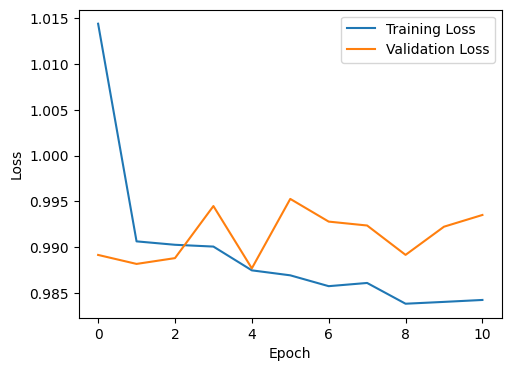

In [61]:
import matplotlib.pyplot as plt
# Plot the training history
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

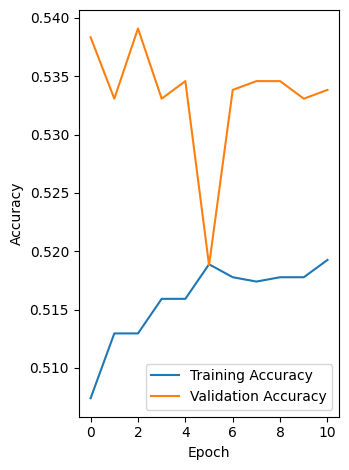

In [62]:
# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [63]:
model.save("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/final/nafi/GRUcbow.h5")  # Save the model in an h5 format

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
